In [1]:
import os
import pickle
from typing import Tuple

from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

In [2]:
from typing import Tuple
from matplotlib.figure import Figure
from matplotlib.axes import Axes


def fig_axs_interpret_cluster(
    wave: np.array,
    mean_anomaly: np.array,
    median_anomaly: np.array,
    median_weights: np.array,
    mean_weights: np.array,
    fig_size=None,
) -> Tuple[Figure, Axes]:
    """
    Plot the mean and median anomaly and the mean and median
    explanation weights.

    INPUT

    wave: wavelength array
    mean_anomaly: mean anomaly array
    median_anomaly: median anomaly array
    median_weights: median explanation weights array
    mean_weights: mean explanation weights array
    fig_size: figure size

    OUTPUT

    fig: figure
    axs: axes
    """

    fig, axs = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=fig_size,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    axs[0].plot(wave, median_anomaly, c="black", label="Median")
    axs[0].set_ylabel("Normalized flux", fontsize=8)

    axs[1].plot(wave, mean_anomaly, c="black", label="Mean")
    axs[1].set_ylabel("Normalized flux", fontsize=8)

    axs[2].plot(wave, median_weights, color="black", label="Median")
    axs[2].plot(wave, mean_weights, color="blue", label="Mean")

    axs[2].set_ylabel("Explanation weight", fontsize=8)
    axs[2].set_ylim(0, 1.01)

    return fig, axs

In [3]:
# constants
# sdss_band = {
#     "u": (3698, 4200),
#     "g": (3800, 5400),
#     "r": (5300, 7000), 
#     "i": (7000, 7500),
# }

# region_name = "sdss_band"

sdss_band = {
    "0": (3750, 4050),
    "1": (5020, 6500),
    "2": (6750, 7500), 
}
region_name = "sdss_continuum"

In [4]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12"
iml_use_case_directory = (
    f"{user}/explain-me-why/sections/" "figures/iml_use_cases"
)

clustering_directory = (
    f"{user}/explain-me-why/sections/figures/iml_use_cases/"
    "cluster_regions_of_interest"
)


# metric = "mse_filter_250kms_noRel97"
metric = "mse_noRel100"
# metric = "mse_filter_250kms_noRel100"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = f"{work_directory}/{bin_id}/explanation/{model}/{metric}"

In [5]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz", index_col="specobjid"
)

# load the weights
explanation_weights = np.load(
    f"{data_directory}/explanation_weights/weights_all_abs_"
    f"smooth_True_drop_0.05_{metric}_bin_03.npy"
)

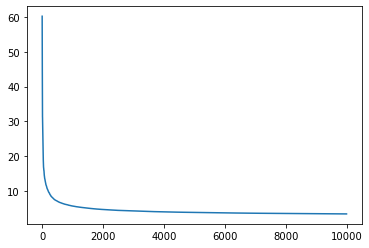

In [6]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
# reverse spectra in anomalies array as well
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

In [7]:
explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

## Clustering of weights for different colors SDSS bands

In [8]:
# generate mask for the sdss bands

for key, value in sdss_band.items():
    mask = wave > value[0]
    mask &= wave < value[1]
    sdss_band[key] = mask

In [9]:
for key, value in sdss_band.items():
    print(key, value.sum())

0 288
1 1480
2 749


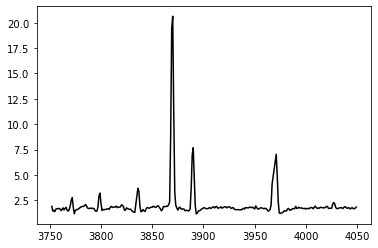

In [10]:
# test_band = "i"
test_band = "0"
plt.plot(
    wave[sdss_band[f"{test_band}"]],
    anomalies[0][sdss_band[f"{test_band}"]],
    color="black",
)

In [11]:
# create dictionary to store arrays of weights for each sdss band

sdss_weights = {}
anomalies_sdss_bands = {}
wave_sdss_bands = {}
for key, value in sdss_band.items():

    sdss_weights[key] = explanation_weights[:, value]
    anomalies_sdss_bands[key] = anomalies[:, value]
    wave_sdss_bands[key] = wave[value]

    print(key, sdss_weights[key].shape)

0 (10000, 288)
1 (10000, 1480)
2 (10000, 749)


In [12]:
# create a dictionary to store the inertias for each sdss band 
# and the number of clusters
n_clusters = range(2, 12)

sdss_band_inertia = {}

for key, value in sdss_weights.items():

        inertias = []

        for n in n_clusters:

            print(f"{key} band, cluster {n}", end="\r")

            kmeans = KMeans(n_clusters=n, random_state=0).fit(value)
            inertias.append(kmeans.inertia_)

        sdss_band_inertia[key] = np.array(inertias) 



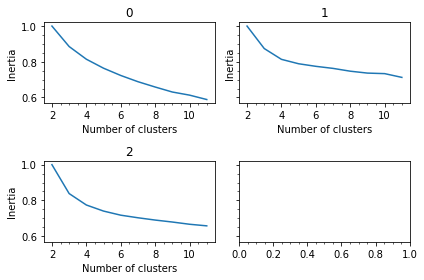

In [13]:
# Normalize the inertias for each sdss band

for key, value in sdss_band_inertia.items():
    
        sdss_band_inertia[key] = value / value.max()

# plot the inertias for each sdss band

fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=None,
    sharex=False,
    sharey=True,
    tight_layout=True,
)

for ax in axs.flat: ax.minorticks_on()

for i, key in enumerate(sdss_band_inertia.keys()):
    axs[i // 2, i % 2].plot(n_clusters, sdss_band_inertia[key])
    axs[i // 2, i % 2].set_title(key)
    axs[i // 2, i % 2].set_xlabel("Number of clusters")
    axs[i // 2, i % 2].set_ylabel("Inertia")

fig.savefig(
    f"{clustering_directory}/"
    f"kmeans_inertias_region_{region_name}_{metric}.pdf"
)

In [14]:
# Use kmeans to cluster the weights for each sdss band

n_clusters = 6

sdss_band_kmeans = {}
cluster_directory = f"{data_directory}/kmeans_models"
for key, value in sdss_weights.items():
    
        print(f"{key} band", end="\r")
    
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(value)
        sdss_band_kmeans[key] = kmeans

        # save the kmeans model

        with open(
            f"{clustering_directory}/kmeans_{region_name}_{key}_"
            f"n_clusters_{n_clusters}_{metric}.pkl",
            "wb",
        ) as f:
        
            pickle.dump(kmeans, f)

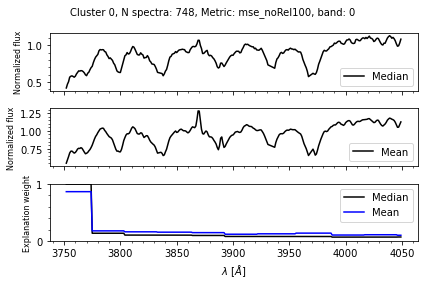

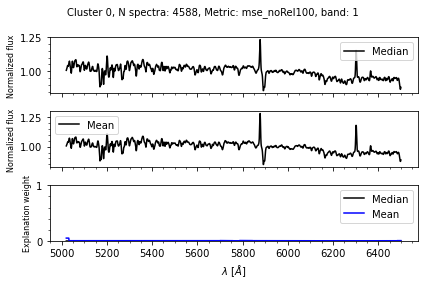

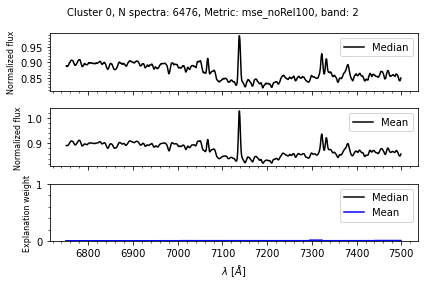

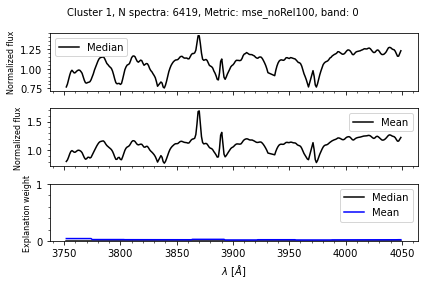

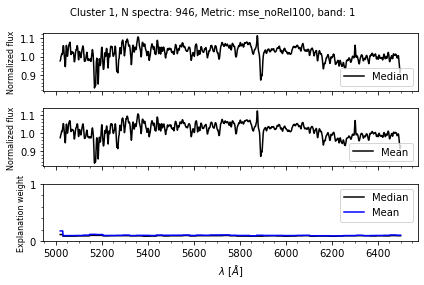

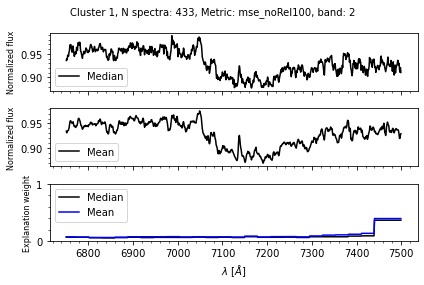

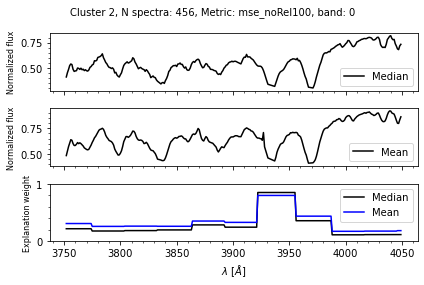

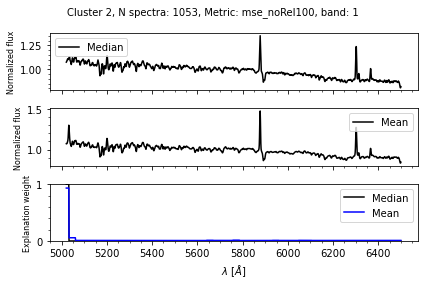

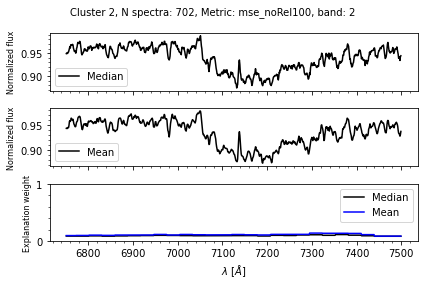

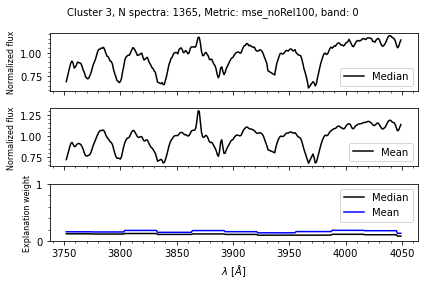

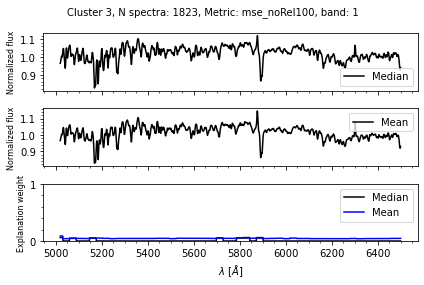

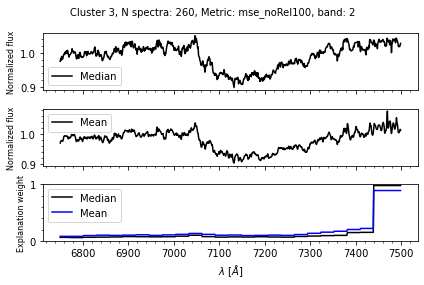

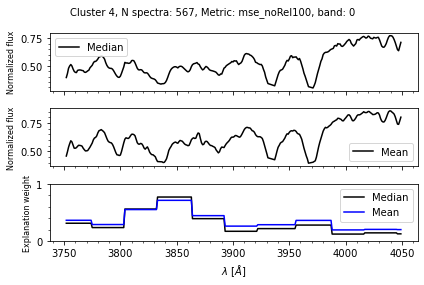

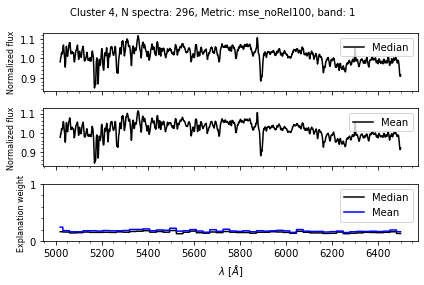

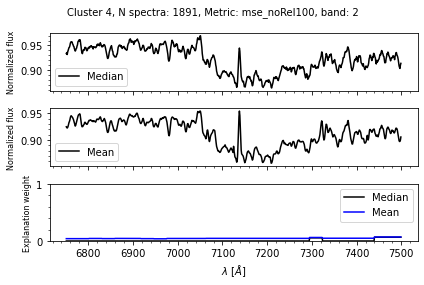

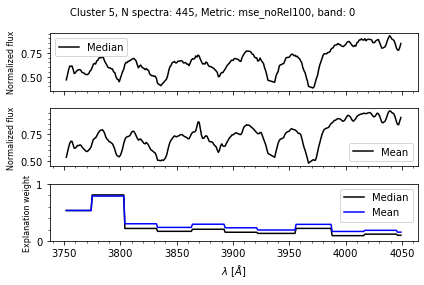

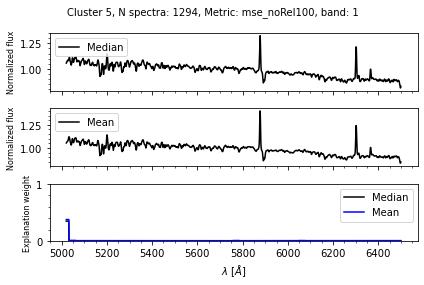

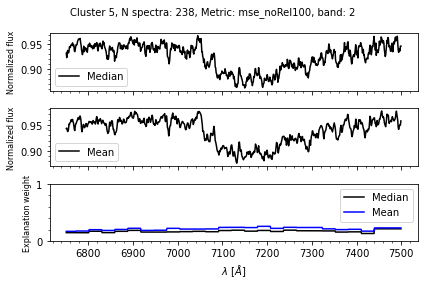

In [15]:
# plot mean and median of the anomalies and explanation weights
# for each sdss band for each cluster

for cluster_number in range(n_clusters):

    for key, value in sdss_weights.items():

        cluster_mask = sdss_band_kmeans[key].labels_ == cluster_number

        cluster_anomalies = anomalies_sdss_bands[key][cluster_mask]

        n_spectra_in_cluster = cluster_anomalies.shape[0]
        cluster_mean_anomalies = cluster_anomalies.mean(axis=0)
        cluster_median_anomalies = np.median(cluster_anomalies, axis=0)

        cluster_weights = sdss_weights[key][cluster_mask]
        cluster_median_weights = np.median(cluster_weights, axis=0)
        cluster_mean_weights = cluster_weights.mean(axis=0)
        
        wave_band = wave_sdss_bands[key]

        fig, axs = fig_axs_interpret_cluster(
            wave=wave_band,
            mean_anomaly=cluster_mean_anomalies,
            median_anomaly=cluster_median_anomalies,
            median_weights=cluster_median_weights,
            mean_weights=cluster_mean_weights,
            fig_size=None,
        )

        axs[2].set_xlabel("$\lambda$ [$\AA$]")

        for ax in axs:
            ax.legend()
            ax.minorticks_on()

        fig.suptitle(
            (
                f"Cluster {cluster_number}, "
                f"N spectra: {n_spectra_in_cluster}, "
                f"Metric: {metric}, "
                f"band: {key}"
            ),
            fontsize=10,
        )

        # create cluster directory if it does not exist
        save_to = f"{clustering_directory}/band_{key}"

        if not os.path.exists(save_to):
            os.makedirs(save_to)

        fig.savefig(
            f"{save_to}/band_{key}_"
            f"cluster_{cluster_number}_metric_{metric}_bin_{bin_id}.pdf"
        )
